In [ ]:
!pip install torch-geometric

Epoch 0 | Loss: 0.9633
Epoch 10 | Loss: 0.7333
Epoch 20 | Loss: 0.6653
Epoch 30 | Loss: 0.6247
Epoch 40 | Loss: 0.6090
Epoch 50 | Loss: 0.5985
Epoch 60 | Loss: 0.5902
Epoch 70 | Loss: 0.5847
Epoch 80 | Loss: 0.5797
Epoch 90 | Loss: 0.5756

GCN Accuracy: 66.67%


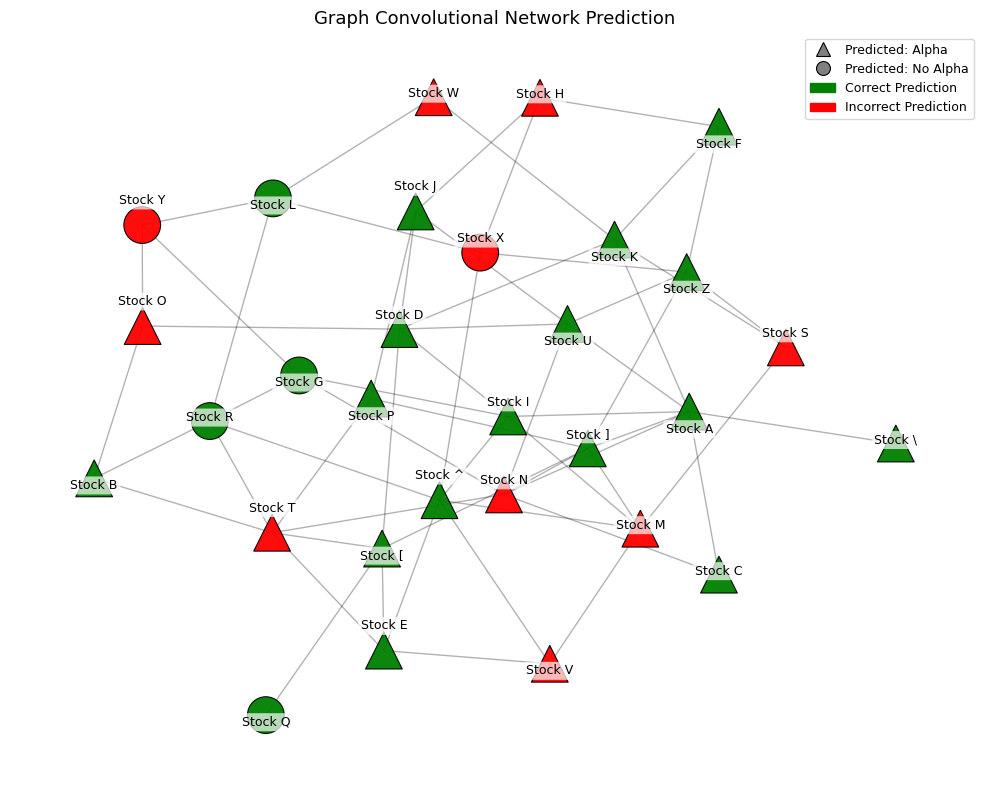

In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import accuracy_score
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from sklearn.metrics import accuracy_score

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

num_nodes = 30
G_nx = nx.erdos_renyi_graph(num_nodes, 0.15)

features = np.random.randn(num_nodes, 3)
x = torch.tensor(features, dtype=torch.float)

labels = []
for node in G_nx.nodes:
    neighbors = list(G_nx.neighbors(node))
    count_div7 = sum(1 for n in neighbors if n % 7 == 0)
    labels.append(int(count_div7 == 1))
y = torch.tensor(labels, dtype=torch.long)

x += torch.tensor(y.unsqueeze(1).numpy() * 0.1 + np.random.randn(num_nodes, 3) * 0.2, dtype=torch.float)

edge_index = torch.tensor(list(G_nx.edges), dtype=torch.long).t().contiguous()
data = Data(x=x, edge_index=edge_index, y=y)

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(3, 8)
        self.conv2 = GCNConv(8, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(95):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1).cpu()

true_y = data.y.cpu().numpy()
pred_y = pred.numpy()

acc = accuracy_score(true_y, pred_y)
print(f"\nGCN Accuracy: {acc * 100:.2f}%")

node_colors = ['green' if t == p else 'red' for t, p in zip(true_y, pred_y)]

shape_map = {0: 'o', 1: '^'}
node_shapes = [shape_map[p] for p in pred_y]

pos = nx.kamada_kawai_layout(G_nx)

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G_nx, pos, alpha=0.3)

for shape in ['^', 'o']:
    idxs = [i for i, s in enumerate(node_shapes) if s == shape]
    nx.draw_networkx_nodes(
        G_nx,
        pos,
        nodelist=idxs,
        node_color=[node_colors[i] for i in idxs],
        node_shape=shape,
        node_size=700,
        edgecolors='black',
        linewidths=0.8,
        alpha=0.95
    )

for i, (x_coord, y_coord) in pos.items():
    y_jitter = 0.03 * ((i % 5) - 2)
    plt.text(x_coord, y_coord + y_jitter, f"Stock {chr(65 + i)}",
             fontsize=9, ha='center',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))

legend_elements = [
    Line2D([0], [0], marker='^', color='w', label='Predicted: Alpha',
           markerfacecolor='gray', markeredgecolor='black', markeredgewidth=0.8, markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Predicted: No Alpha',
           markerfacecolor='gray', markeredgecolor='black', markeredgewidth=0.8, markersize=10),
    mpatches.Patch(color='green', label='Correct Prediction'),
    mpatches.Patch(color='red', label='Incorrect Prediction')
]
plt.legend(handles=legend_elements, loc='upper right', frameon=True, fontsize=9)

plt.title("Graph Convolutional Network Prediction", fontsize=13)
plt.axis("off")
plt.tight_layout()
plt.show()
